In [1]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from scipy.stats import ttest_ind
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import random
import joblib
import torch

def seed(seed=42):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [2]:
# 1. CSV 불러오기
df_preprocess = pd.read_csv("preprocessed_data/Scenario A1-ARFF/Scenario A1-ARFF_15s-VPN.csv")
le = LabelEncoder()
df_preprocess['class1'] = le.fit_transform(df_preprocess['class1'])
print(le.classes_)

['Non-VPN' 'VPN']


In [3]:
df_preprocess

,duration,total_fiat,total_biat,min_fiat,min_biat,max_fiat,max_biat,mean_fiat,mean_biat,flowPktsPerSecond,...,std_flowiat,min_active,mean_active,max_active,std_active,min_idle,mean_idle,max_idle,std_idle,class1
0,9368711.0,16.0,4.0,1564818.0,1549373.0,190205.285714,203290.456522,389822.391917,370323.719754,10.353612,...,267600.198443,1871488.0,1.983656e+06,2195089.0,1.832197e+05,1234883.0,1420565.0,1523088.0,161096.539275,0
1,7340238.0,18.0,4.0,1567554.0,1527893.0,165686.977273,186914.846154,317267.548742,304370.651301,11.580006,...,221462.862028,1491627.0,3.572433e+06,5653239.0,2.942704e+06,1131498.0,1324636.0,1517774.0,273138.379008,0
2,4644225.0,29.0,15.0,1270547.0,1079974.0,165865.178571,195302.130435,329473.126261,300492.588227,11.412022,...,217475.425246,1758922.0,1.758922e+06,1758922.0,0.000000e+00,1079974.0,1079974.0,1079974.0,0.000000,0
3,4978735.0,19.0,8.0,2492050.0,2457286.0,239543.250000,276596.388889,612435.304238,628339.573544,8.034169,...,436959.716436,1710925.0,2.382905e+06,3054885.0,9.503232e+05,1346073.0,1894031.5,2441990.0,774930.342317,0
4,11838189.0,19.0,10.0,3094089.0,3093543.0,243766.500000,295954.725000,599721.781709,625632.703972,7.602514,...,436129.639296,1747431.0,2.400446e+06,3240696.0,6.232744e+05,1394455.0,1983227.0,3042717.0,725987.829075,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18033,73240.0,-1.0,-1.0,-1.0,-1.0,0.000000,0.000000,0.000000,0.000000,27.307482,...,0.000000,-1.0,0.000000e+00,-1.0,0.000000e+00,-1.0,0.0,-1.0,0.000000,0
18034,52083.0,-1.0,-1.0,-1.0,-1.0,0.000000,0.000000,0.000000,0.000000,38.400246,...,0.000000,-1.0,0.000000e+00,-1.0,0.000000e+00,-1.0,0.0,-1.0,0.000000,0
18035,67923.0,-1.0,-1.0,-1.0,-1.0,0.000000,0.000000,0.000000,0.000000,29.445107,...,0.000000,-1.0,0.000000e+00,-1.0,0.000000e+00,-1.0,0.0,-1.0,0.000000,0
18036,313588.0,-1.0,-1.0,-1.0,-1.0,0.000000,0.000000,0.000000,0.000000,6.377795,...,0.000000,-1.0,0.000000e+00,-1.0,0.000000e+00,-1.0,0.0,-1.0,0.000000,0


In [4]:
def corr_remove(df):
    fig, ax = plt.subplots(figsize=(14, 14))

    # 상관관계 히트맵 시각화
    corr = df.corr()
    sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', ax=ax)
    ax.set_title('Correlation Heatmap')
    plt.tight_layout()
    plt.show()

    remove_col = []

    # 1. 상수값 컬럼 제거
    for col in df.columns:
        if df[col].nunique() <= 1:
            print(f"{col} 는 상수 — 제거 대상")
            remove_col.append(col)

    # 3. class1 기준 t-test로 유의미한 차이 없는 컬럼 제거
    if 'class1' in df.columns and df['class1'].nunique() == 2:
        group0 = df[df['class1'] == 0]
        group1 = df[df['class1'] == 1]

        for col in df.columns:
            if col == 'class1' or col in remove_col:
                continue

            try:
                t_stat, p_val = ttest_ind(group0[col], group1[col], equal_var=False, nan_policy='omit')
                if p_val > 0.05:
                    print(f"{col} 는 t-test 결과 유의하지 않음 (p={p_val:.4f}) - 제거 대상")
                    remove_col.append(col)
            except Exception as e:
                print(f"{col} 처리 중 오류 발생: {e}")
                
    # 4. 상호 상관관계가 0.9 이상인 컬럼 쌍 중 하나 제거 (class와 무관)
    high_corr_pairs = []
    for i in corr.columns:
        for j in corr.columns:
            if i >= j:  # 중복 또는 자기 자신은 skip
                continue
            if abs(corr.loc[i, j]) > 0.9:
                pair = tuple(sorted((i, j)))
                high_corr_pairs.append(pair)

    # 중복 제거: 두 번째 컬럼을 제거
    for col1, col2 in high_corr_pairs:
        if col2 not in remove_col:
            print(f"{col1} 와 {col2} 의 상관관계가 0.9 이상 - {col2} 제거")
            remove_col.append(col2)

    # 최종 중복 제거 및 정렬
    remove_col = sorted(set(remove_col))
    print("\n✅ 최종 제거할 컬럼들:", len(remove_col), remove_col)

    # 실제 제거
    df_cleaned = df.drop(columns=remove_col)
    return df_cleaned

In [5]:
def train_test(df):
    # 특성과 레이블 나누기
    X = df.drop(columns=['class1'])
    y = df['class1']

    # train/valid/test 분리
    X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
    X_train, X_valid, y_train, y_valid = train_test_split(X_temp, y_temp, test_size=0.25, stratify=y_temp, random_state=42)
    return X_train, y_train, X_valid, y_valid, X_test, y_test

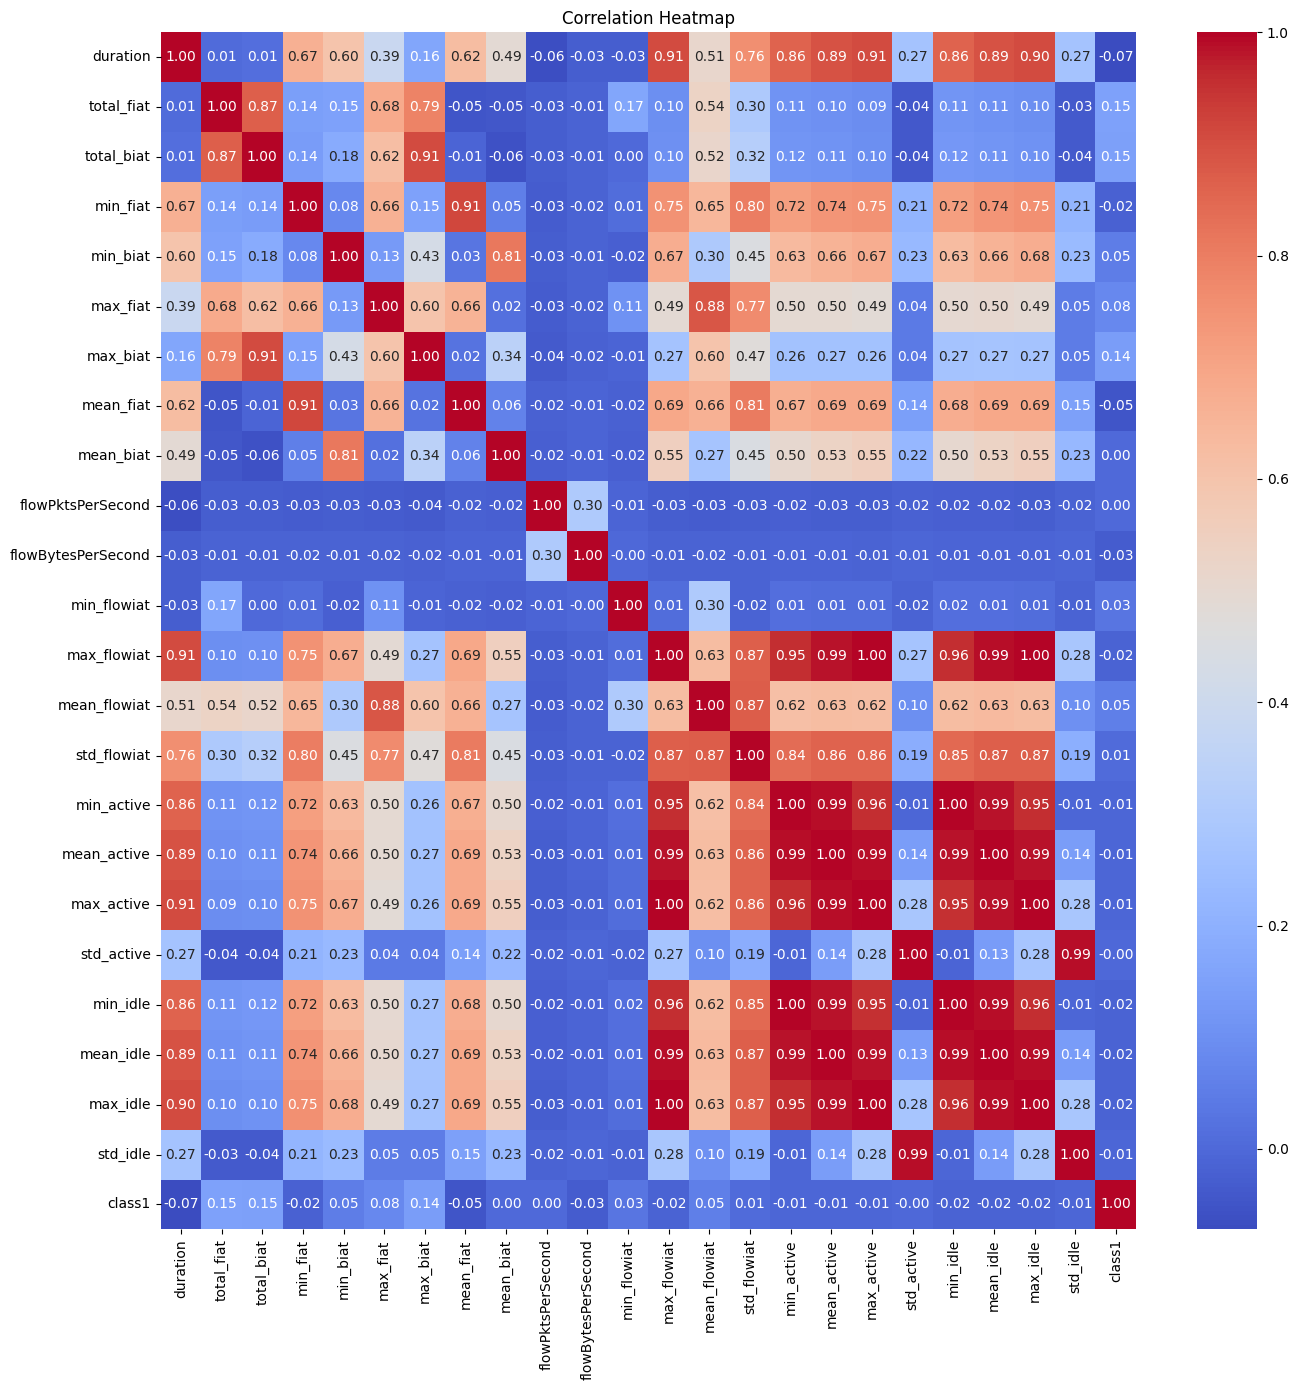

mean_biat 는 t-test 결과 유의하지 않음 (p=0.6651) - 제거 대상
flowPktsPerSecond 는 t-test 결과 유의하지 않음 (p=0.7054) - 제거 대상
std_flowiat 는 t-test 결과 유의하지 않음 (p=0.3973) - 제거 대상
min_active 는 t-test 결과 유의하지 않음 (p=0.2551) - 제거 대상
mean_active 는 t-test 결과 유의하지 않음 (p=0.2182) - 제거 대상
max_active 는 t-test 결과 유의하지 않음 (p=0.2316) - 제거 대상
std_active 는 t-test 결과 유의하지 않음 (p=0.5892) - 제거 대상
std_idle 는 t-test 결과 유의하지 않음 (p=0.3493) - 제거 대상
duration 와 max_flowiat 의 상관관계가 0.9 이상 - max_flowiat 제거
duration 와 max_idle 의 상관관계가 0.9 이상 - max_idle 제거
max_biat 와 total_biat 의 상관관계가 0.9 이상 - total_biat 제거
mean_fiat 와 min_fiat 의 상관관계가 0.9 이상 - min_fiat 제거
max_flowiat 와 min_idle 의 상관관계가 0.9 이상 - min_idle 제거
max_flowiat 와 mean_idle 의 상관관계가 0.9 이상 - mean_idle 제거

✅ 최종 제거할 컬럼들: 14 ['flowPktsPerSecond', 'max_active', 'max_flowiat', 'max_idle', 'mean_active', 'mean_biat', 'mean_idle', 'min_active', 'min_fiat', 'min_idle', 'std_active', 'std_flowiat', 'std_idle', 'total_biat']


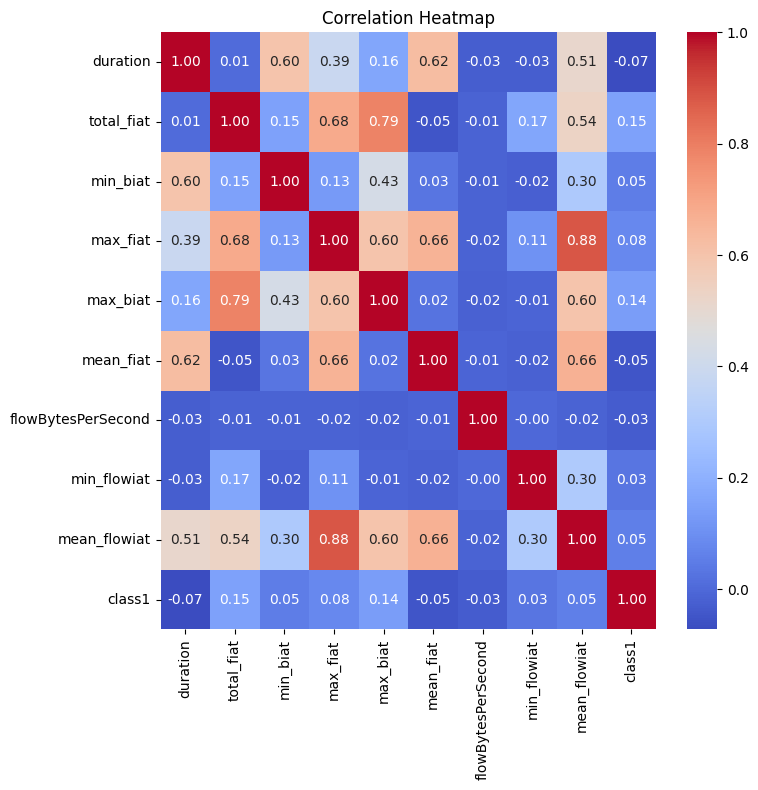

In [6]:
df_preprocess_cleaned = corr_remove(df_preprocess)

fig, ax = plt.subplots(figsize=(8, 8))

# 상관관계 히트맵
corr = df_preprocess_cleaned.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', ax=ax)
ax.set_title('Correlation Heatmap')

plt.tight_layout()
plt.show()

In [8]:
seed()
print(list(df_preprocess_cleaned.columns))
X_train, y_train, X_valid, y_valid, X_test, y_test = train_test(df_preprocess_cleaned)

# 모델 학습
model = XGBClassifier(eval_metric='logloss', n_estimators=1000)
model.fit(
    X_train, y_train,
    eval_set=[(X_valid, y_valid)],
    verbose=50,
)

# 예측 및 평가 (문자 클래스 복원)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

joblib.dump(model, "vpn_pipeline.joblib")

['duration', 'total_fiat', 'min_biat', 'max_fiat', 'max_biat', 'mean_fiat', 'flowBytesPerSecond', 'min_flowiat', 'mean_flowiat', 'class1']
[0]	validation_0-logloss:0.57407
[50]	validation_0-logloss:0.23917
[100]	validation_0-logloss:0.22017
[150]	validation_0-logloss:0.21557
[200]	validation_0-logloss:0.21750
[250]	validation_0-logloss:0.22198
[300]	validation_0-logloss:0.22481
[350]	validation_0-logloss:0.22820
[400]	validation_0-logloss:0.23305
[450]	validation_0-logloss:0.23764
[500]	validation_0-logloss:0.24159
[550]	validation_0-logloss:0.24448
[600]	validation_0-logloss:0.24862
[650]	validation_0-logloss:0.25318
[700]	validation_0-logloss:0.25537
[750]	validation_0-logloss:0.25909
[800]	validation_0-logloss:0.26222
[850]	validation_0-logloss:0.26427
[900]	validation_0-logloss:0.26731
[950]	validation_0-logloss:0.26924
[999]	validation_0-logloss:0.27169
              precision    recall  f1-score   support

           0       0.91      0.92      0.92      1738
           1       0

['vpn_pipeline.joblib']